In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
import time
import pandas as pd
from mpl_toolkits import mplot3d

from torch.distributions import Normal as norm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Gaussian(nn.Module):
    def __init__(self, mu, rho):
        super(Gaussian, self).__init__()
        self.norm   = norm(0,0.1)
        self.mu_    = mu
        self.rho_   = rho
        self.sigma_ = torch.ones(self.mu_.shape)
        
        
    def sample(self):
        self.eps    = self.norm.sample(self.mu_.shape).type(self.mu_.type()).to(device)
        self.sigma_ = torch.log(1 + torch.exp(self.rho_))
        self.W      = self.mu_ + self.sigma_ * self.eps
        return self.W
            
    def loss(self):
        return (0.5*self.mu_**2 + 0.5*self.sigma_ - torch.log(1e-20 + self.sigma_)).sum()

In [4]:
class Blinear(nn.Module):
    def __init__(self, n_input, n_output):
        super(Blinear, self).__init__()
        
        self.n_input  = n_input
        self.n_output = n_output
        
        self.mu       = nn.Parameter(torch.randn(n_output, n_input))
        
        self.rho      = nn.Parameter(torch.ones(n_output, n_input))
        
        self.W        = Gaussian(self.mu, self.rho)

        self.b_mu     = nn.Parameter(torch.randn(n_output))
        self.b_rho    = nn.Parameter(torch.ones(n_output))
        self.b        = Gaussian(self.b_mu, self.b_rho)



#         self.n_input  = n_input
#         self.n_output = n_output
        
        
        
#         self.mu    = nn.Parameter(torch.Tensor(n_output, n_input).normal_(0., .05))  # or .01
#         self.rho   = nn.Parameter(torch.Tensor(n_output, n_input).uniform_(-3., -3.))
        
#         self.W     = Gaussian(self.mu, self.rho)
        
#         self.b_mu  = nn.Parameter(torch.Tensor(n_output).normal_(0., .05))
#         self.b_rho = nn.Parameter(torch.Tensor(n_output).uniform_(-3., -3.))
        
#         self.b     = Gaussian(self.b_mu, self.b_rho) 
        
    def forward(self, x):
        
        W = self.W.sample()
        b = self.b.sample()
        
        return F.linear(x, W, b)

In [5]:
class NN(nn.Module):
    def __init__(self, Layers, act = nn.Tanh()):
        super(NN, self).__init__()
        
        
        self.act = act
        self.fc  = nn.ModuleList()
        
        for i in range(len(Layers) - 1):
            self.fc.append(Blinear(Layers[i], Layers[i+1]))
            
    def forward(self, x):
        for i in range(len(self.fc)-1):
            x = self.fc[i](x)
            x = self.act(x)
        x = self.fc[-1](x)
        return x
    

In [6]:
class Net():
    def __init__(self, x, u, xx, layers, activation = nn.Tanh(), n_ep = 2000):
        
        
        self.n_ep      = n_ep
        self.x         = x.clone().detach().requires_grad_(False)
        self.xx        = xx.clone().detach().requires_grad_(True)
        
        perm           = torch.randperm(x.size(0))
        idx            = perm[:20]
        self.zz        = xx[idx].clone().detach().requires_grad_(False)
        
        
        self.u         = u
        
        self.n_layers  = len(layers)
        self.act       = activation
        self.u_net     = NN(layers, self.act)
        
        self.His_loss  = []
        self.His_acc  = []
    
        
        
    def get_loss(self):
        
        y_hat   = self.u_net(self.x)
            
        loss_1 = (y_hat - self.u).square().mean()

#         u_hat   = y_hat + self.u_net.poly_(self.x)
#         loss_1  = (u_hat - self.u).square().mean()


        
#         yy      = self.u_net(self.xx)
#         uu      = yy + self.u_net.poly_(self.xx)

        uu = self.u_net(self.xx)
               
        
        du_hat = torch.autograd.grad(uu.sum(), self.xx, create_graph=True)[0]
#         du_hat, = torch.autograd.grad(uu,
#                             self.xx,
#                             create_graph=True,
#                             retain_graph=True,
#                             grad_outputs=torch.ones(uu.shape))
        

        loss_2 = (du_hat[:,0] + du_hat[:,1] - 3*self.xx[:,0] - self.xx[:,1]).square().mean()
    
#         loss_3 = self.u_net.R(self.zz)
        
        return loss_1 + loss_2 #+ loss_3
        
        
    def train(self, X_star = None, u_star = None):    
        optimizer = torch.optim.SGD(self.u_net.parameters(), lr = 4e-4, momentum = 0.95)
#         optimizer = torch.optim.Adam(self.u_net.parameters(), lr=5e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=.95)
        for n in range(self.n_ep):
            
            loss = self.get_loss()
            with torch.no_grad():
                _u_hat_ = 0
                for _ in range(100):
                    _y_hat_ = self.u_net(Z)
                    _u_hat_ += _y_hat_.reshape(-1,)/100
                self.His_acc.append((_u_hat_ - y).square().sum()/200)
                
                self.His_loss.append(loss.item())
                
            if n % 100 == 0:
                print(n)
                with torch.no_grad():
                    print(loss.item())
                    
                    

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

In [7]:
def boundary(x):
    return x[:,0]**2 + x[:,0]*x[:,1]

In [8]:
# Z = torch.zeros(200,2)

In [9]:
# Z[:, 0] = torch.Tensor(200).uniform_(-1., 1.)
# Z[:, 1] = torch.Tensor(200).uniform_(-1., 1.)
# y = boundary(Z)

In [10]:
# y = 1/(1+25*Z[:, 0]**2)

In [11]:
Layers = [2, 100, 1]

In [12]:
k =100
a = torch.linspace(-1, 1, steps=k)
b = torch.linspace(-1, 1, steps=k)
grid_x, grid_y = torch.meshgrid(a, b, indexing='ij')
XX = torch.zeros((k**2, 2))
XX[:,0] = grid_x.reshape(-1)
XX[:,1] = grid_y.reshape(-1)

In [13]:
perm     = torch.randperm(XX.size(0))
idx      = perm[:200]
Z        = XX[idx]
y = boundary(Z)

In [14]:
Z.shape

torch.Size([200, 2])

In [15]:
#Z

In [16]:
model = Net(Z, y, XX, Layers)

In [17]:
beta = 1

In [18]:
model.train()

0
168.6460418701172
100
4.524144649505615
200
2.353618860244751
300
5.38697624206543
400
2.398308753967285
500
2.0095763206481934
600
4.4610819816589355
700
4.593805313110352
800
1.2339274883270264
900
3.9384353160858154
1000
4.904668807983398
1100
3.335685968399048
1200
4.498023986816406
1300
5.107952117919922
1400
4.043209075927734
1500
3.3113436698913574
1600
1.0094698667526245
1700
1.414137363433838
1800
0.6606930494308472
1900
0.7709888219833374


In [19]:
u_hat = 0
for _ in range(100):
    y_hat = model.u_net(Z)
    u_hat += y_hat.reshape(-1,)/100
print((u_hat - y).square().sum()/200)

tensor(0.2865, grad_fn=<DivBackward0>)


In [20]:
import matplotlib.pyplot as plt

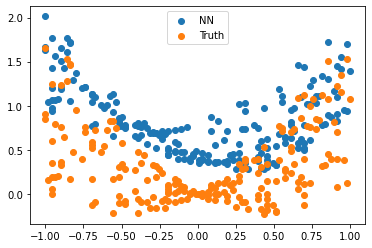

In [21]:
plt.scatter(Z[:, 0].detach().numpy(), u_hat.detach().numpy(), label = 'NN')
plt.scatter(Z[:, 0].detach().numpy(), y.detach().numpy(), label = "Truth")
plt.legend()
plt.show()

In [22]:
W = Z + 0
W[:,1] =0
#W

In [23]:
y_ = boundary(W)

In [24]:
u_hat_ = 0
for _ in range(100):
    y_hat_ = model.u_net(W)
    u_hat_ += y_hat_.reshape(-1,)/100 #+ model.u_net.poly_(W)
print((u_hat_ - y_).square().sum()/1000)

tensor(0.0178, grad_fn=<DivBackward0>)


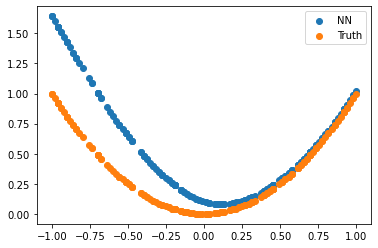

In [25]:
plt.scatter(W[:, 0].detach().numpy(), u_hat_.detach().numpy(), label = 'NN')
plt.scatter(W[:, 0].detach().numpy(), y_.detach().numpy(), label = "Truth")
plt.legend()
plt.show()

In [26]:
a = torch.linspace(-1, 1, steps=100)
b = torch.linspace(-1, 1, steps=100)
grid_x, grid_y = torch.meshgrid(a, b, indexing='ij')

In [27]:
XX = torch.zeros((10000, 2))
XX[:,0] = grid_x.reshape(-1)
XX[:,1] = grid_y.reshape(-1)

In [28]:
u_hat_ = torch.zeros(10000)
for _ in range(100):    
    y_hat_ = model.u_net(XX)
    u_hat_ += y_hat_.reshape(-1,)/100 

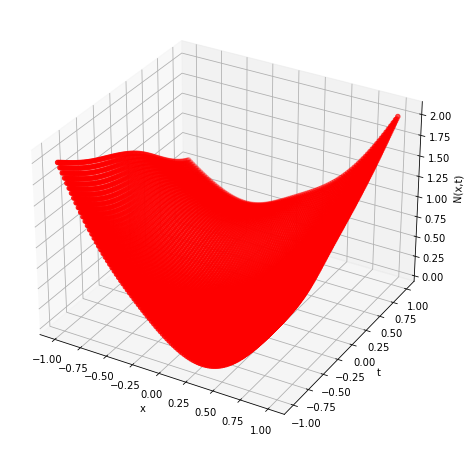

In [29]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(grid_x, grid_y, u_hat_.detach().numpy(), color = 'r')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('N(x,t)')
plt.show()

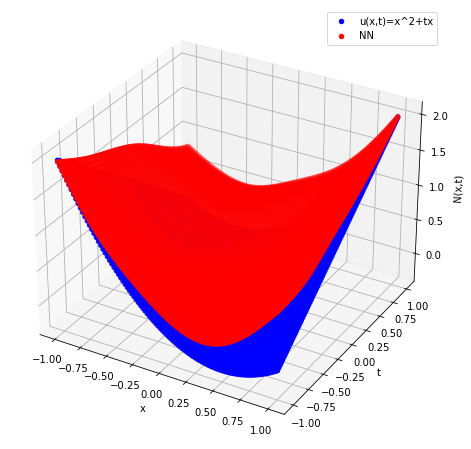

In [30]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(grid_x, grid_y,(grid_x**2 + grid_x*grid_y), label = 'u(x,t)=x^2+tx', color = 'b')
ax.scatter3D(grid_x, grid_y, u_hat_.detach().numpy(), label = 'NN', color = 'r')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('N(x,t)')
plt.legend()
plt.show()

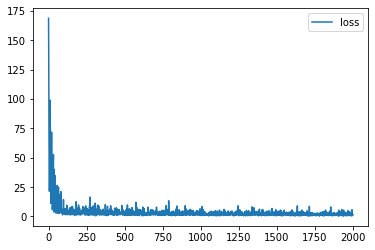

In [31]:
plt.plot(model.His_loss, label = "loss")
plt.legend()
plt.show()

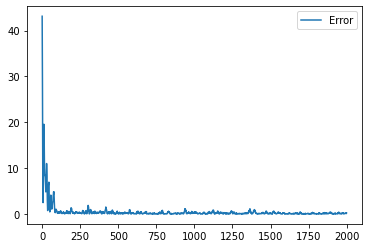

In [32]:
plt.plot(model.His_acc, label = "Error")
plt.legend()
plt.show()